# Bug triage with Deep Learning

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 20 # 40
MAX_SEQUENCE_LENGTH_D = 200 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [8]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, 'eclipse.csv', MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

#### Loading bug ids in memory

In [9]:
baseline.load_ids(DIR)
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [10]:
%%time

baseline.load_preprocess()
len(baseline.sentence_dict)

100%|██████████| 212512/212512 [00:37<00:00, 5687.72it/s]

CPU times: user 36 s, sys: 1.52 s, total: 37.5 s
Wall time: 37.4 s


## Geração de batches

### Generating tiple of batches

In [11]:
%%time
baseline.prepare_dataset()

Reading train data
CPU times: user 181 ms, sys: 4.03 ms, total: 185 ms
Wall time: 182 ms


In [12]:
baseline.load_bugs()

100%|██████████| 212512/212512 [00:10<00:00, 19405.51it/s]


In [13]:
baseline.bug_set[2521]

{'bug_severity': '6\n',
 'bug_status': '1\n',
 'component': '227\n',
 'creation_ts': '2001-10-10 22:38:00 -0400',
 'delta_ts': '2005-05-10 14:55:51 -0400',
 'description': 'steps minimize all your windows go to any window and select the window menu pick any window notice that it only gets selected and not maximized this happens in country as well notes',
 'description_word': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,

In [14]:
%%time

batch_size = 1024
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(baseline.DIR, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

CPU times: user 62.3 ms, sys: 4.2 ms, total: 66.5 ms
Wall time: 66.2 ms


In [15]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_input_sample['info'].shape, valid_sim.shape

((512, 20), (512, 200), (512, 1682), (512,))

### Validar entrada

In [16]:
%%time 

baseline.display_batch(5)

***Title***: when a file is edited and saved with ctrl s eclipse crashes
***Title***: eclipse organization crashes after saving file
***Description***: organization person x u country x en country rv person organization el firefox person when a file is edited and saved with ctrl s eclipse crashes it is very deterministic as it happens every time an edited file is saved with ctrl s it can be reproduced very easily organization also crashes if an edited file is saved by clicking on the save button however this does not happen every time but occurs most of the times reproducible always person to person open a artwork project in eclipse edit a file press ctrl s to save the edited file
***Description***: organization anytime i save a java source file organization crashes after the file is saved the ordinal couple of lines from the log file are money an unexpected error has been detected by person money sigsegv xb at pc xadeca pid tid money person person bit organization b mixed mode linux a

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [17]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)

1917494it [01:17, 24775.51it/s]


Total 1917494 word vectors in Glove 42B 300d.
Found 128293 unique tokens.


100%|██████████| 128293/128293 [00:00<00:00, 1672218.49it/s]


CPU times: user 1min 34s, sys: 2.97 s, total: 1min 37s
Wall time: 1min 36s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [18]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  # best combination filter (3, 4, 5) e 128 e 256
  convs = []
  filter_sizes = [3, 4, 5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=256, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [19]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 50
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### MLP

In [20]:
def mlp_model(input_size):
    info_input = Input(shape=(input_size, ), name='Feature_BugInput')
    
    x = Dense(input_size)(info_input)
    x = Dense(input_size // 2)(x)
    
    layer = Dense(256)(x)
    
    mlp_feature_model = Model(inputs=[info_input], outputs=[layer], name = 'FeatureMlpGenerationModel')
    
    return mlp_feature_model

### Siamese model

In [21]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

In [22]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, mlp_feature_model, sequence_length_info, max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')
    
    bug_i_in = Input(shape = (sequence_length_info, ), name = 'info_in')
    bug_i_pos = Input(shape = (sequence_length_info, ), name = 'info_pos')
    bug_i_neg = Input(shape = (sequence_length_info, ), name = 'info_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)
    
    bug_i_in_feat_mlp = mlp_feature_model(bug_i_in)
    bug_i_pos_feat_mlp = mlp_feature_model(bug_i_pos)
    bug_i_neg_feat_mlp = mlp_feature_model(bug_i_neg)

    encoded_anchor = concatenate([bug_i_in_feat_mlp, bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_i_pos_feat_mlp, bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_i_neg_feat_mlp, bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, 
                                       bug_d_in, bug_d_pos, bug_d_neg, 
                                       bug_i_in, bug_i_pos, bug_i_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

In [ ]:
%%time
import keras
from keras.callbacks import ModelCheckpoint

# Inspired on https://pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

number_of_columns_info = valid_input_sample['info'].shape[1]

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

mlp_feature_model = mlp_model(number_of_columns_info)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, mlp_feature_model, 
                                     number_of_columns_info, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)
# checkpoint
filepath="baseline_1000epoch_10steps_1024batch(eclipse).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                               #validation_data=test_gen, # 
                                             epochs = 1000,
                                             verbose = True,
                                               callbacks=[tbCallBack, checkpoint]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_in (InputLayer)            (None, 1682)         0                                            
__________________________________________________________________________________________________
title_in (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
info_pos (InputLayer)           (None, 1682)         0                                            
__________________________________________________________________________________________________
title_pos 

10/10 [==============================] - 5s 473ms/step - loss: 0.9167 - pos_distance: 0.5547 - neg_distance: 0.4713

Epoch 00013: loss improved from 0.91915 to 0.91667, saving model to baseline_1000epoch_10steps_1024batch(eclipse).hdf5
Epoch 14/1000
10/10 [==============================] - 5s 468ms/step - loss: 0.9190 - pos_distance: 0.5491 - neg_distance: 0.4681

Epoch 00014: loss did not improve from 0.91667
Epoch 15/1000
10/10 [==============================] - 5s 473ms/step - loss: 0.9189 - pos_distance: 0.5566 - neg_distance: 0.4755

Epoch 00015: loss did not improve from 0.91667
Epoch 16/1000
10/10 [==============================] - 5s 471ms/step - loss: 0.9193 - pos_distance: 0.5471 - neg_distance: 0.4664

Epoch 00016: loss did not improve from 0.91667
Epoch 17/1000
10/10 [==============================] - 5s 474ms/step - loss: 0.9180 - pos_distance: 0.5430 - neg_distance: 0.4610

Epoch 00017: loss did not improve from 0.91667
Epoch 18/1000
10/10 [==============================]

10/10 [==============================] - 5s 473ms/step - loss: 0.8578 - pos_distance: 0.4854 - neg_distance: 0.3432

Epoch 00061: loss did not improve from 0.85366
Epoch 62/1000
10/10 [==============================] - 5s 469ms/step - loss: 0.8563 - pos_distance: 0.4804 - neg_distance: 0.3367

Epoch 00062: loss did not improve from 0.85366
Epoch 63/1000
10/10 [==============================] - 5s 471ms/step - loss: 0.8619 - pos_distance: 0.4859 - neg_distance: 0.3479

Epoch 00063: loss did not improve from 0.85366
Epoch 64/1000
10/10 [==============================] - 5s 471ms/step - loss: 0.8521 - pos_distance: 0.4975 - neg_distance: 0.3496

Epoch 00064: loss improved from 0.85366 to 0.85209, saving model to baseline_1000epoch_10steps_1024batch(eclipse).hdf5
Epoch 65/1000
10/10 [==============================] - 5s 473ms/step - loss: 0.8503 - pos_distance: 0.4798 - neg_distance: 0.3302

Epoch 00065: loss improved from 0.85209 to 0.85033, saving model to baseline_1000epoch_10steps_1024

10/10 [==============================] - 5s 473ms/step - loss: 0.8148 - pos_distance: 0.4790 - neg_distance: 0.2937

Epoch 00102: loss did not improve from 0.80733
Epoch 103/1000
10/10 [==============================] - 5s 472ms/step - loss: 0.8147 - pos_distance: 0.4765 - neg_distance: 0.2912

Epoch 00103: loss did not improve from 0.80733
Epoch 104/1000
10/10 [==============================] - 5s 472ms/step - loss: 0.8212 - pos_distance: 0.4561 - neg_distance: 0.2773

Epoch 00104: loss did not improve from 0.80733
Epoch 105/1000
10/10 [==============================] - 5s 468ms/step - loss: 0.8066 - pos_distance: 0.4704 - neg_distance: 0.2769

Epoch 00105: loss improved from 0.80733 to 0.80655, saving model to baseline_1000epoch_10steps_1024batch(eclipse).hdf5
Epoch 106/1000
10/10 [==============================] - 5s 471ms/step - loss: 0.8039 - pos_distance: 0.4603 - neg_distance: 0.2641

Epoch 00106: loss improved from 0.80655 to 0.80389, saving model to baseline_1000epoch_10steps_

10/10 [==============================] - 5s 467ms/step - loss: 0.7914 - pos_distance: 0.4726 - neg_distance: 0.2641

Epoch 00143: loss did not improve from 0.78069
Epoch 144/1000
10/10 [==============================] - 5s 472ms/step - loss: 0.7926 - pos_distance: 0.4650 - neg_distance: 0.2576

Epoch 00144: loss did not improve from 0.78069
Epoch 145/1000
10/10 [==============================] - 5s 465ms/step - loss: 0.7972 - pos_distance: 0.4701 - neg_distance: 0.2673

Epoch 00145: loss did not improve from 0.78069
Epoch 146/1000
10/10 [==============================] - 5s 469ms/step - loss: 0.7830 - pos_distance: 0.4873 - neg_distance: 0.2703

Epoch 00146: loss did not improve from 0.78069
Epoch 147/1000
10/10 [==============================] - 5s 470ms/step - loss: 0.8176 - pos_distance: 0.4856 - neg_distance: 0.3032

Epoch 00147: loss did not improve from 0.78069
Epoch 148/1000
10/10 [==============================] - 5s 469ms/step - loss: 0.7915 - pos_distance: 0.4824 - neg_distan

10/10 [==============================] - 5s 470ms/step - loss: 0.7774 - pos_distance: 0.4732 - neg_distance: 0.2506

Epoch 00186: loss did not improve from 0.76614
Epoch 187/1000
10/10 [==============================] - 5s 466ms/step - loss: 0.7654 - pos_distance: 0.4632 - neg_distance: 0.2286

Epoch 00187: loss improved from 0.76614 to 0.76541, saving model to baseline_1000epoch_10steps_1024batch(eclipse).hdf5
Epoch 188/1000
10/10 [==============================] - 5s 471ms/step - loss: 0.7821 - pos_distance: 0.4705 - neg_distance: 0.2526

Epoch 00188: loss did not improve from 0.76541
Epoch 189/1000
10/10 [==============================] - 5s 468ms/step - loss: 0.7741 - pos_distance: 0.4832 - neg_distance: 0.2573

Epoch 00189: loss did not improve from 0.76541
Epoch 190/1000
10/10 [==============================] - 5s 471ms/step - loss: 0.7636 - pos_distance: 0.4709 - neg_distance: 0.2345

Epoch 00190: loss improved from 0.76541 to 0.76361, saving model to baseline_1000epoch_10steps_

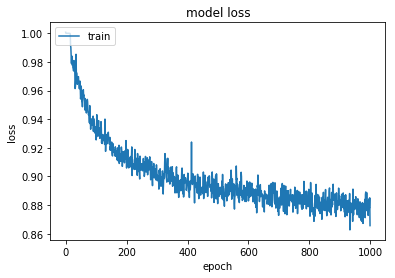

In [25]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

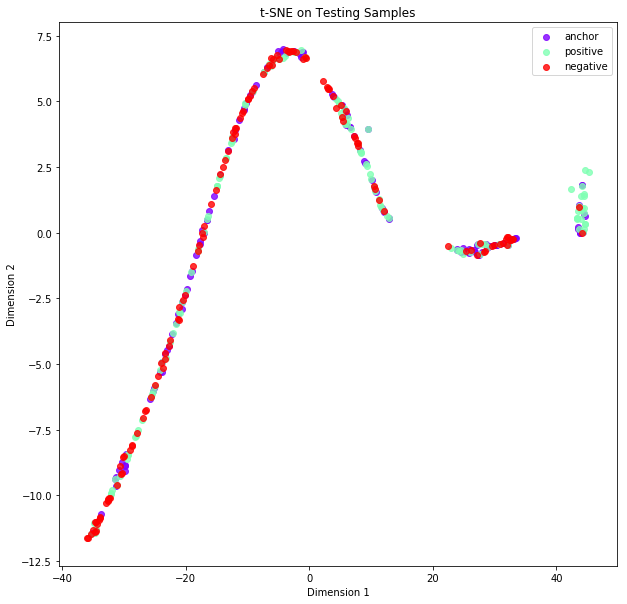

CPU times: user 2.91 s, sys: 1.37 s, total: 4.28 s
Wall time: 3.15 s


In [26]:
%%time
baseline.display_embed_space(similarity_model, 128)

In [27]:
name = 'baseline_1000epoch_10steps_1024batch(eclipse)'
Baseline.save_model('', similarity_model, name)

Saved model to disk
